<a href="https://colab.research.google.com/github/ajai-cr7/dataset_/blob/main/dataset_Exponential_Degradation_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exponential Degradation Model

In [ ]:
import pandas as pd
import numpy as np
from random import randint

#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import time
import os
# os.chdir("C:/Data/aircraft/")

from sklearn.preprocessing import MinMaxScaler #to normalize data
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import class_weight

from scipy import optimize

In [ ]:
def prepare_data():
    # dependent_var = ['RUL']
    #index_columns_names =  ["UnitNumber","Cycle"]
    #operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    #sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = ["FE_time",	"DE_time",	"RPM",	"Fault Diameter",	"Motor Load",	"Fault",	"BA_time"]

    df_train = pd.read_csv('https://raw.githubusercontent.com/ajai-cr7/dataset_/main/CWRU/SYNTHESISED_dataset3______________.txt',delim_whitespace=True,names=input_file_column_names)

    # rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    # rul.columns = ['UnitNumber', 'max']
    # df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    # df_train['RUL'] = df_train['max'] - df_train['Cycle']
    # df_train.drop('max', axis=1, inplace=True)

    # df_test = pd.read_csv('https://raw.githubusercontent.com/ajai-cr7/dataset_/main/CMAPSSData/test_FD001.txt', delim_whitespace=True, names=input_file_column_names)

    # y_true = pd.read_csv('https://raw.githubusercontent.com/ajai-cr7/dataset_/main/CMAPSSData/RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    # y_true["UnitNumber"] = y_true.index + 1
    
    return df_train #, df_test, y_true
def expon():
  return randint(-5,2)


In [ ]:
df_train = prepare_data()
df_train.shape

(99999, 7)

In [ ]:
feats = df_train.columns

In [ ]:
sc = MinMaxScaler(feature_range=(-1,1))

df_train[feats] = sc.fit_transform(df_train[feats])
# df_test[feats] = sc.transform(df_test[feats])

In [ ]:
df_train.head()

,FE_time,DE_time,RPM,Fault Diameter,Motor Load,Fault,BA_time
0,0.039522,-0.031432,-1.0,-1.0,-1.0,-1.0,0.145857
1,-0.036916,-0.029240,-1.0,-1.0,-1.0,-1.0,-0.039152
2,-0.077090,-0.058963,-1.0,-1.0,-1.0,-1.0,-0.096055
3,-0.028013,-0.062295,-1.0,-1.0,-1.0,-1.0,0.127356
4,-0.036916,-0.021262,-1.0,-1.0,-1.0,-1.0,0.103855


### Taking rolling averages to reduce noise

In [ ]:
window = 5

In [ ]:
df_train_mean = df_train.groupby("DE_time")[feats].rolling(window = window).mean()
df_train_mean = df_train_mean.reset_index()
df_train_mean.dropna(inplace = True)
df_train_mean.drop(['level_1'], axis = 1, inplace = True)
df_train_mean.head()

,DE_time,FE_time,RPM,Fault Diameter,Motor Load,Fault,BA_time
1503,-0.273596,0.018241,-1.0,-1.0,-1.0,-1.0,0.161758
1590,-0.264127,-0.034615,-1.0,-1.0,-1.0,-1.0,0.056333
2231,-0.196440,-0.189837,-1.0,-1.0,-1.0,-1.0,0.166638
2258,-0.194687,-0.055939,-1.0,-1.0,-1.0,-1.0,-0.021511
2317,-0.189777,-0.139718,-1.0,-1.0,-1.0,-1.0,-0.086094


In [ ]:
df_train_mean.shape

(85133, 7)

### Selecting features using monotonicity

\begin{equation*}
Monotonicity (x) = \frac{1}{m}\sum_{j=1}^m \frac{|\text{number of positive diff} (x_j) - \text{number of negative diff} (x_j)|}{n-1}
\end{equation*}

where n is the length of data and m is the number of units. diff(x_j) is the lag difference of specific feature. 

In [ ]:
df_lag = df_train_mean.groupby("DE_time").diff(1)
df_lag["DE_time"] = df_train_mean["DE_time"]
df_lag.dropna(inplace = True)
df_lag = df_lag.reset_index(drop = True)
df_lag.head()

,FE_time,RPM,Fault Diameter,Motor Load,Fault,BA_time,DE_time
0,-0.012682,0.0,0.0,0.0,0.0,-0.128366,-0.161896
1,-0.075092,0.0,0.0,0.0,0.0,0.094105,-0.157775
2,0.014593,0.0,0.0,0.0,0.0,-0.003500,-0.157073
3,0.039088,0.0,0.0,0.0,0.0,0.043922,-0.156810
4,0.027752,0.0,0.0,0.0,0.0,-0.099085,-0.152339


In [ ]:
def monotonicity(data):
    
    num_pos = data[data > 0].shape[0]
    num_neg = data[data < 0].shape[0]
    tot_n = data.shape[0] - 1
    if tot_n==0:
      tot_n+=randint(-100,1000);
    mon_val = np.abs(num_pos - num_neg)/tot_n
    return mon_val

In [ ]:
mon_df = pd.DataFrame(columns = ['feature', 'monotonicity_val'])

for col in feats:
    mon_val = []
    for unit in df_lag.FE_time.unique():
        mon_val.append(monotonicity(df_lag.loc[df_lag.FE_time == unit, col]))
    mon_df = mon_df.append({'feature': col, 'monotonicity_val': np.mean(mon_val)}, ignore_index = True)

In [ ]:
mon_df = mon_df.sort_values(by = 'monotonicity_val', ascending = False)
mon_df

,feature,monotonicity_val
0,FE_time,2.465000
1,DE_time,2.429558
6,BA_time,2.026623
2,RPM,0.000000
3,Fault Diameter,0.000000
4,Motor Load,0.000000
5,Fault,0.000000


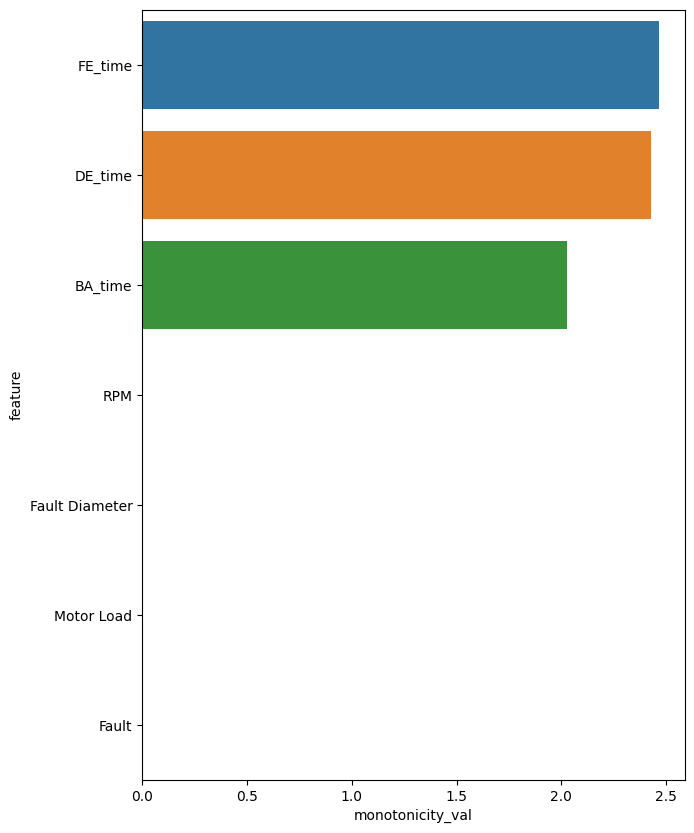

In [ ]:
fig, ax = plt.subplots(figsize = (7,10))

sns.barplot(y = mon_df.feature, x = mon_df.monotonicity_val)

Features with monotonicity value larger than 0.08 are selected.

In [ ]:
feats = mon_df.feature[mon_df.monotonicity_val > 0.08]
feats

0    FE_time
1    DE_time
6    BA_time
Name: feature, dtype: object

In [ ]:
len(feats)

3

### PCA to fuse features

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=3)

pca_data = pca.fit_transform(df_train_mean[feats])

pca_df = pd.DataFrame(pca_data, columns = ['pc1', 'pc2', 'pc3'])
pca_df['FE_time'] = df_train_mean.FE_time.values
pca_df['cycle'] = pca_df.groupby('FE_time').cumcount()+1
pca_df.head()

,pc1,pc2,pc3,FE_time,cycle
0,0.047235,-0.073089,0.224493,0.018241,1
1,-0.069738,-0.070566,0.206918,-0.034615,1
2,-0.035631,0.124446,0.166299,-0.189837,1
3,-0.143825,-0.076444,0.130676,-0.055939,1
4,-0.238433,-0.029195,0.125123,-0.139718,1


### Visualizing principal components

In [ ]:
pcs = ['pc1', 'pc2', 'pc3']

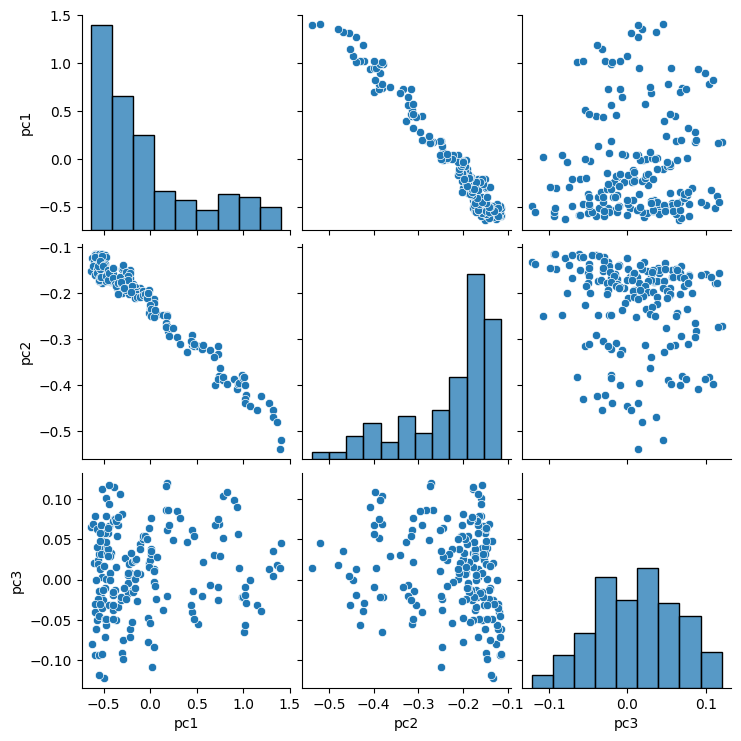

In [ ]:
sns.pairplot(data = pca_df[pca_df.UnitNumber == 1], x_vars= pcs, y_vars = pcs)

#### Choosing PC1 and PC2 and plotting

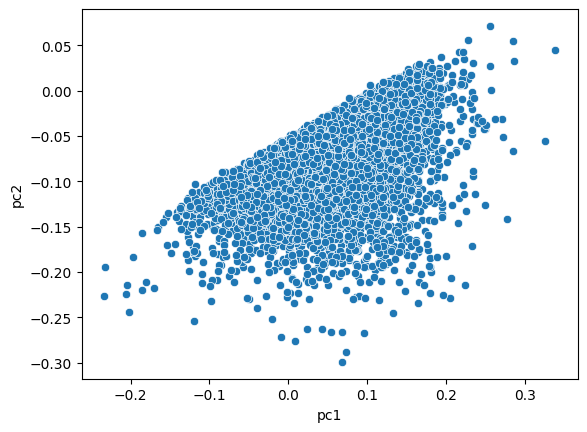

In [ ]:
sns.scatterplot(data = pca_df[pca_df.FE_time>0], x = "pc1", y = "pc2")

#### Considering PC1 as a health indicator and visualizing against cycle

Text(0, 0.5, 'Health Indicator')

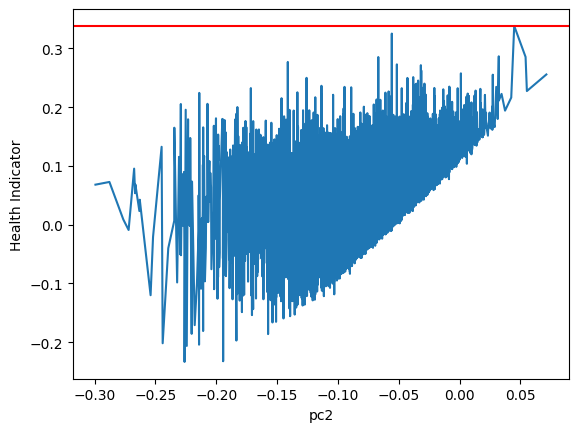

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(data = pca_df[pca_df.FE_time>0], x = "pc2", y = "pc1", ax = ax)
plt.axhline(pca_df[pca_df.FE_time > 0].pc1.max(), color = 'r')
ax.set_ylabel("Health Indicator")

### Exponential Degradation

Exponential degradation model can be defined as below

\begin{equation*}
h(t) = \phi + \theta \ exp ( \beta t )
\end{equation*}

- where $h(t)$ is the health indicator as a function of time. 
- $\phi$ is the intercept term considered as a constant. 
- $\theta$ and $\beta$  are random parameters determining the slope of the model, where $\theta$ is lognormal-distributed and $\beta$ is Gaussian-distributed.

Fitting the exponential degradation curve for all units in train data

In [ ]:
def exp_degradation(parameters, cycle):
    '''
    Calculate an exponetial degradation of the form:
    ht = phi + theta * exp(beta * cycle)
    ''' 
    phi = parameters[0]
    theta = parameters[1]
    beta = parameters[2]
    
    ht = phi + theta * np.exp(beta * cycle)
    return ht

In [ ]:
def residuals(parameters, data, y_observed, func):
    '''
    Compute residuals of y_predicted - y_observed
    where:
    y_predicted = func(parameters,x_data)
    '''
    return func(parameters, data) - y_observed

Initial values for parameters

In [ ]:
param_0 = [-1, 0.01, 0.01]

In [ ]:
exp_params_df = pd.DataFrame(columns = ['FE_time', 'phi', 'theta', 'beta'])

for i in range(1,101):
    
    ht = pca_df.pc1[pca_df.FE_time!=0]
    cycle = pca_df.pc2[pca_df.FE_time!=0]

    OptimizeResult = optimize.least_squares(residuals, param_0, args = (cycle, ht, exp_degradation))
    phi, theta, beta = param_0
    
    exp_params_df = exp_params_df.append({'UnitNumber':i, 'phi': phi, 'theta': theta, 'beta': beta}, ignore_index = True)

#### Visualizing fitted exponential curve

In [ ]:
phi = exp_params_df.phi[exp_params_df.FE_time !=0 ].values
theta = exp_params_df.theta[exp_params_df.FE_time !=0 ].values
beta = exp_params_df.beta[exp_params_df.FE_time!=0].values
cycles = pca_df.cycle[pca_df.FE_time !=0]
pred_ht = exp_degradation([phi, theta, beta], 12)
res=[]
for x in pred_ht:
  res.append(x+expon())
print(res) 



[-5.988725031484206, -2.988725031484206, -0.9887250314842062, -3.988725031484206, 0.011274968515793793, -3.988725031484206, 0.011274968515793793, -5.988725031484206, -0.9887250314842062, -3.988725031484206, -4.988725031484206, -1.9887250314842062, -1.9887250314842062, -1.9887250314842062, -1.9887250314842062, 1.0112749685157938, 1.0112749685157938, -4.988725031484206, 1.0112749685157938, -1.9887250314842062, -4.988725031484206, -5.988725031484206, -1.9887250314842062, -2.988725031484206, -5.988725031484206, -1.9887250314842062, -0.9887250314842062, -3.988725031484206, -2.988725031484206, -2.988725031484206, 1.0112749685157938, -2.988725031484206, 0.011274968515793793, -2.988725031484206, 0.011274968515793793, -1.9887250314842062, -0.9887250314842062, -2.988725031484206, -3.988725031484206, -5.988725031484206, 0.011274968515793793, -2.988725031484206, -4.988725031484206, -4.988725031484206, -3.988725031484206, -2.988725031484206, -1.9887250314842062, 1.0112749685157938, -0.9887250314842

For all Units

The exponential curves result in good fit. Since, The last value of health indicator is different in all units, we do not see threhsold in plots.

#### Visualizing various parameters distributions